# Count LAT memory errors and plot errors in timespan on a map

### Robert Cameron, August 2015

In [1]:
from ipywidgets import *
from IPython.display import *
%matplotlib notebook
from datetime import *
import re
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt, mpld3

In [2]:
# read ASCII file of LAT memory errors
# example line:
#EPU1: 2015-07-29 23:36:33.466179 (1438212993.466179)  Address:  122126272 (0x07477fc0)  Type: 3 (Correctable single-bit error) -13.696137 -25.135624 1
err_count = {}
yesterday = ''
dates = []
day_out = []
day_in = []
lon_in = []
lat_in = []
lon_out = []
lat_out = []
with open("/Users/rac/Documents/GLAST/ISOC/LATmetrics/memerr/geosaa.out") as fi:
    for line in fi:
        if not re.search(' [01]$', line):
            continue
        line = re.sub('[\(\)\:]',' ',line)
        fields = line.split()
        key1 = fields[0]  # SIU, EPU0 or EPU1
        key2 = (fields[0],fields[10])    # and error type 3 (single-bit) or 4 (multi-bit)
        today = fields[1]
        err_count[key1] = err_count.get(key1, 0) + 1
        err_count[key2] = err_count.get(key2, 0) + 1
        if today != yesterday:
            dates.append(today)
            day_out.append(len(lon_out))
            day_in.append(len(lon_in))
            yesterday = today
        if int(fields[-1]) == 1:
            lon_in.append(fields[-3])
            lat_in.append(fields[-2])
        else:
            lon_out.append(fields[-3])
            lat_out.append(fields[-2])
fi.close()

In [3]:
date = datetime.strptime(today, '%Y-%m-%d')
tomorrow = date + timedelta(days=1)
dates.append(tomorrow.strftime('%Y-%m-%d'))
dates[0], dates[-1], len(dates), len(day_in), len(day_out), len(lon_in), len(lon_out), len(lon_in)+len(lon_out)
ndays = len(dates)

In [4]:
err_total = err_count['SIU']+err_count['EPU0']+err_count['EPU1']
print ("Cumulative Errors\tSIU\tEPU0\tEPU1")
print ("Single Bit\t\t%d\t%d\t%d" % (err_count[('SIU','3')],err_count[('EPU0','3')],err_count[('EPU1','3')]))
print ("Double Bit\t\t%d\t%d\t%d" % (err_count[('SIU','4')],err_count[('EPU0','4')],err_count[('EPU1','4')]))
print ("Totals\t\t\t%d\t%d\t%d" % (err_count['SIU'],err_count['EPU0'],err_count['EPU1']))
saapc = 100*len(lon_in)/err_total
print ("\nFor %s to %s: %s days: %s Total Errors, with %d%% inside SAA" % (dates[0],dates[-1],ndays,err_total,saapc))

Cumulative Errors	SIU	EPU0	EPU1
Single Bit		32183	12481	35674
Double Bit		600	215	824
Totals			32783	12696	36498

For 2008-08-02 to 2017-09-01: 3316 days: 81977 Total Errors, with 92% inside SAA


In [5]:
saapercent = 100*len(lon_in)/err_total
saapercent

92.26856313356186

In [6]:
# define the SAA region
saalon = [ 33.9,  24.5, -18.6, -25.7, -36.0, -42.0, -58.8, -93.1, -97.5, -98.5, -92.1, -86.1,  33.9]
saalat = [-30.0, -22.6,   2.5,   5.2,   5.2,   4.6,   0.7,  -8.6,  -9.9, -12.5, -21.7, -30.0, -30.0]

<IPython.core.display.Javascript object>


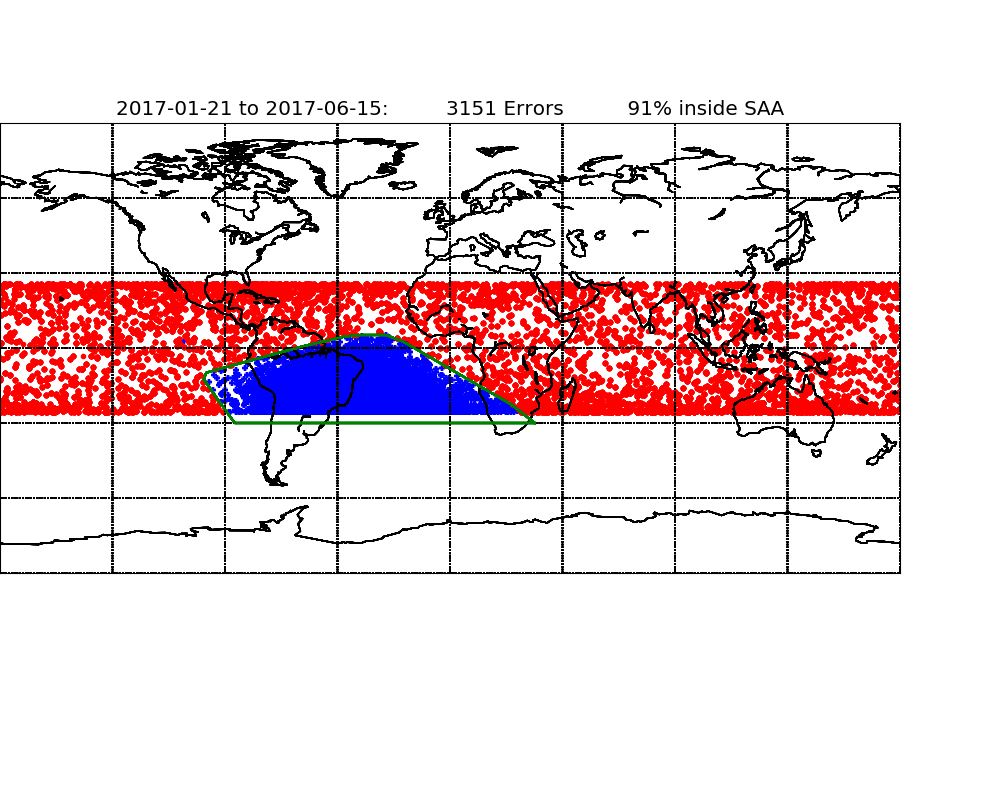

<function __main__.plot_errors>

In [7]:
plt.rc('figure', figsize = [10, 8])
plt.rc('font', size = 12)
plt.subplots_adjust(left=0.00, bottom=0.25)
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-180,urcrnrlon=180)
def plot_errors(begin, end): 
    bin = day_in[begin]
    ein = day_in[end]
    bout = day_out[begin]
    eout = day_out[end]
    nin = ein-bin
    nout = eout-bout
    ntot = nin+nout
    saapc = 100*nin/ntot
    m.drawcoastlines()
    m.drawparallels(np.arange(-90.,91.,30.))
    m.drawmeridians(np.arange(-180.,181.,45.))
    m.plot(saalon,saalat,linewidth=1.5,color='g')
    m.scatter(lon_in[bin:ein],lat_in[bin:ein],s=15,marker='+',color='b')
    m.scatter(lon_out[bout:eout],lat_out[bout:eout],s=9,marker='o',color='r')
    plt.title("%s to %s:         %s Errors          %d%% inside SAA" % (dates[begin],dates[end],ntot,saapc))
    plt.show()
    mpld3.enable_notebook()
interact(plot_errors, begin=(0, ndays-1), end=(1, ndays))